# Dog vs. Cat Detection

## Import libraries

In [1]:
#Pre do something

import cv2

## Import Data
the next step is to import the data


In [2]:
TRAIN_DIR = 'C:/Users/Nick/Dropbox/Work/Data Science/06 - dogs v cats/train' #training directory
TEST_DIR = 'C:/Users/Nick/Dropbox/Work/Data Science/06 - dogs v cats/test' #testing directory



Pre-define a function that will take the labels from the image name (thanks to other kernels on Kaggle).

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0] #[cat, not dog]
    elif word_label == 'dog': return [0,1] #[not cat, dog]

## Retrieve training data


In [4]:
#from tqdm import tqdm      # percentage progress bar
#Old do not use
#def create_train_data():
#    training_data = []
#    for img in os.listdir(TRAIN_DIR):
#        label = label_img(img)
#        path = os.path.join(TRAIN_DIR,img)
#        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
#        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
#        training_data.append([np.array(img),np.array(label)])
#    shuffle(training_data)
#    np.save('train_data.npy', training_data)
#    return training_data
#import os
#os.listdir(TRAIN_DIR)[10000:15000]

In [5]:
import cv2
import os
import numpy as np
from tqdm import tqdm 
IMG_SIZE=64 #Define short image size

def create_train_data():
    X = [] #training images
    Y = [] #training labels
    for img in tqdm(os.listdir(TRAIN_DIR)[7000:18000]):
        label = label_img(img)
        path=os.path.join(TRAIN_DIR, img)
        im=cv2.imread(path)
        sh=im.shape
        if sh[0] < sh[1]:  # Find the shortest dimension
            im1=im[0:sh[0],0:sh[0]]
            im2=im[0:sh[0],(sh[1]-sh[0]):sh[1]]
            #rint(""
        else:
            im1=im[0:sh[1],0:sh[0]]
            im2=im[(sh[0]-sh[1]):sh[0],0:sh[1]]
        #Resize images to make them smaller
        im1 = cv2.resize(im1, (IMG_SIZE,IMG_SIZE))
        im2 = cv2.resize(im2, (IMG_SIZE,IMG_SIZE))
        #Append the two images together
        imn=np.append(im1,im2,axis=0)
        X.append(np.array(imn))
        Y.append(np.array(label))
    return(X,Y)
    


Run the new function to create the training data.

In [6]:
X,Y = create_train_data()


100%|████████████████████████████████████████████████████████████████████████████| 11000/11000 [02:27<00:00, 66.23it/s]


In [7]:
#Yp=Y
Y=np.asarray(Y)
Y=Y.astype(np.float32) #Now Y is fixed to a datatype

X=np.asarray(X)
#type(X[1,1,1,1])
X=(X/256).astype(np.float32)
print("Done converting the files")


Done converting the files


Try some of the images to make sure what they look like:

In [8]:
import matplotlib.pyplot as plt
import random
from tflearn.data_utils import shuffle

#index=random.randint(0,25000-1)
#plt.imshow(X[index])
#Y[index]
#X[index].shape

X, Y = shuffle(X, Y)

Xtrain=X[0:9000]
Ytrain=Y[0:9000]
Xtest=X[9000:11000]
Ytest=Y[9000:11000]


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Define the Neural Network
This next section will define the neural network for the detector

In [9]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

#Pre-process the images
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)


# Convolutional network building
network = input_data(shape=[None, IMG_SIZE*2, IMG_SIZE, 3], #Define input layer
                     data_preprocessing=img_prep, #set data_preprocessing
                     data_augmentation=img_aug)

network = conv_2d(network, 32,3, activation='relu') #convolve data once
network = max_pool_2d(network,2) #down sample (reduce data)
network = conv_2d(network, 64, 3, activation='relu')
network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network,2) #down sample (reduce data)
network = max_pool_2d(network, 2)
network = fully_connected(network, 512, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 2, activation='softmax')
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

Run the training iterations repeatedly

In [10]:
#import scipy

#Define the model
model = tflearn.DNN(network, tensorboard_verbose=0, checkpoint_path='dog-cat.tfl.ckpt')
model.fit(Xtrain, Ytrain, n_epoch=25, 
          shuffle=True, 
          validation_set=(Xtest, Ytest),
          show_metric=True, 
          batch_size=96, 
          run_id='catvdog')

Training Step: 2349  | total loss: 0.29755 | time: 571.426s
| Adam | epoch: 025 | loss: 0.29755 - acc: 0.8938 -- iter: 8928/9000
Training Step: 2350  | total loss: 0.28798 | time: 627.161s
| Adam | epoch: 025 | loss: 0.28798 - acc: 0.8982 | val_loss: 0.31414 - val_acc: 0.8625 -- iter: 9000/9000
--
INFO:tensorflow:C:\Users\Nick\Dropbox\Work\Data Science\06 - dogs v cats\dog-cat.tfl.ckpt-2350 is not in all_model_checkpoint_paths. Manually adding it.


Evaluate the accuracy on the testing data (after 2 epochs, the accuracy was 0.756):

In [11]:
model.evaluate(Xtest,Ytest)

[0.86250000000000004]

## Preparation
Now the model is trained. Time to prepare the training data and see what can be done.


In [12]:
def prepare_testing_data():
    Xtest = [] #training images
    filenames = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR, img)
        im=cv2.imread(path)
        sh=im.shape
        if sh[0] < sh[1]:  # Find the shortest dimension
            im1=im[0:sh[0],0:sh[0]]
            im2=im[0:sh[0],(sh[1]-sh[0]):sh[1]]
            #rint(""
        else:
            im1=im[0:sh[1],0:sh[0]]
            im2=im[(sh[0]-sh[1]):sh[0],0:sh[1]]
        #Resize images to make them smaller
        im1 = cv2.resize(im1, (IMG_SIZE,IMG_SIZE))
        im2 = cv2.resize(im2, (IMG_SIZE,IMG_SIZE))
        #Append the two images together
        imn=np.append(im1,im2,axis=0)
        Xtest.append(np.array(imn))
        filenames.append(img)
    return(Xtest,filenames)
    

In [13]:
Xcomp1,fn = prepare_testing_data() #load a portion of the testing data


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [02:43<00:00, 76.57it/s]


In [14]:
Xcomp1=np.asarray(Xcomp1)
Xcomp1=(Xcomp1/256).astype(np.float64)
print("Done")

Done


Now run the model on the testing data

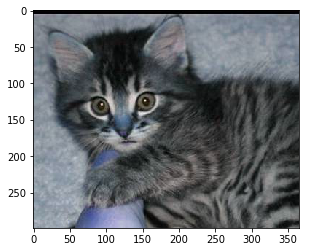

202.jpg
Cat         Dog
1.0000     0.0000


In [52]:
ind=random.randint(0,5000)

path=os.path.join(TEST_DIR, fn[ind])
im=cv2.imread(path)
plt.imshow(im)
plt.show()

#plt.imshow(Xcomp1[ind])
#plt.show()

k=model.predict(np.reshape(Xcomp1[ind],(1,IMG_SIZE*2,IMG_SIZE,3)))

print(fn[ind])
print("Cat         Dog")
print("%2.4f     %2.4f" % (k[0][0], k[0][1]) )

## Create the submission CSV file
The next code section will create a submission .CSV file. 

In [17]:
import csv
fn

index_array=np.empty([12500,1]).astype(np.uint16)
pred_array=np.empty([12500,1]).astype(np.float64)


#index=int(i[:-4])


p=0
for i in tqdm(fn):
    index=int(i[:-4])
    
    pred=model.predict(np.reshape(Xcomp1[p],(1,IMG_SIZE*2,IMG_SIZE,3)))
    
    index_array[index-1]=index
    pred_array[index-1]=pred[0][1]
    p=p+1


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [06:32<00:00, 31.88it/s]


Now write the results to the submission file.

In [18]:
output=np.column_stack((index_array,pred_array))
np.savetxt('submission.csv',
           output,
           comments='',
           fmt='%d, %1.4f',
           delimiter=',',
           header='id,label')